<center>

# Курс "Основы Python для анализа данных"

## Артамонов Игорь Михайлович
## Факультет "Прикладная математика" МАИ

### Практическое занятие № 1. numpy
</center>


## virtualenv + Jupyter notebook

```
<Ctrl> + <Alt> + T - новое окно терминала
```

```
$ conda -V

$ conda update conda

$ conda search "^python$"

$ conda create -n yourenvname python=x.x anaconda

$ source activate yourenvname

$ jupyter notebook

$ conda install -n yourenvname [package]
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
%matplotlib inline

In [2]:
import os
import skimage
import skimage.io
import skimage.transform
import skimage.color

In [3]:
PATH = 'practice01_pics'
image = skimage.io.imread(os.path.join(PATH,'The Abduction of Europa.jpg'))
bad_image = skimage.io.imread(os.path.join(PATH,'The Abduction of Europa-BAD.jpg')) #array rgb

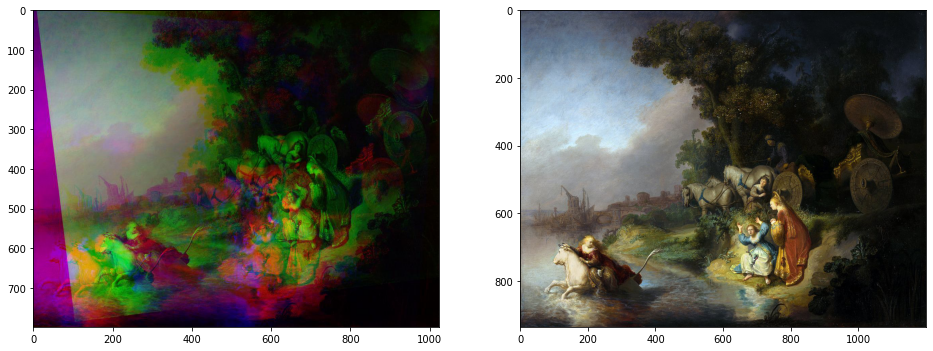

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 40))
ax[0].imshow(bad_image);
ax[1].imshow(image);

In [5]:
# Исследуйте свойства объекта bad_image
type(image)

numpy.ndarray

In [6]:
bad_image.shape

(799, 1024, 3)

In [7]:
bad_image.dtype

dtype('uint8')

In [8]:
lay1 = bad_image[:, :, 0]
lay2 = bad_image[:, :, 1]
lay3 = bad_image[:, :, 2]
print(lay1)

[[78 72 64 ...  9 10 10]
 [79 73 65 ...  9 10 10]
 [79 74 66 ... 10 11 11]
 ...
 [35 37 35 ...  6  6  6]
 [42 44 42 ...  6  6  6]
 [33 35 33 ...  6  6  6]]


## Вопрос 1

* Тип данных, в которые считался файл изображения<br>
numpy.ndarray
* Размер файла изображения<br>
799x1024
* Размерность данных<br>
(799, 1024, 3)
* Тип значений данных<br>
uint8

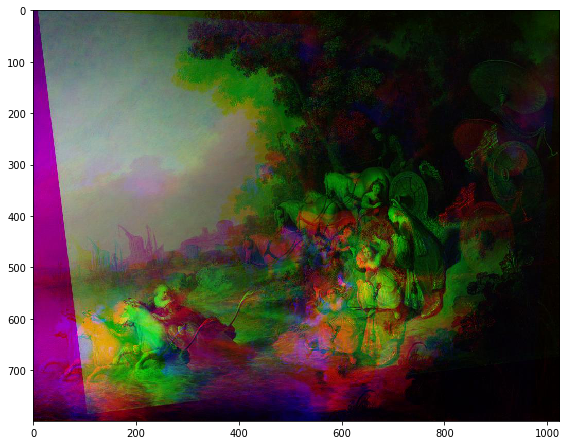

In [9]:
#image = skimage.img_as_float(bad_image)
fig = plt.figure(num=None, figsize=(8, 10))
skimage.io.imshow(bad_image);

### Вопрос 2
Какой слой Вы возьмете за основу и почему?

Первый, т.к. он наименее смещен

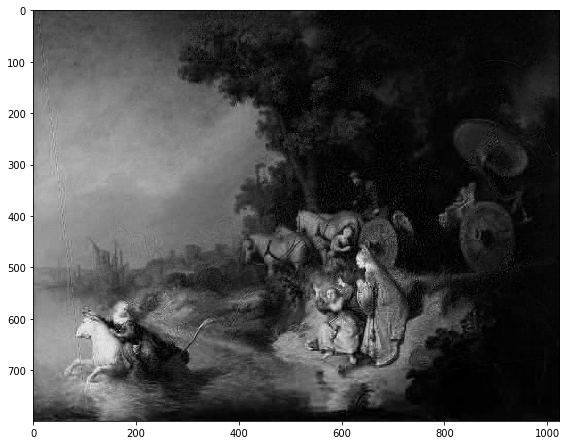

In [10]:
# Ваш код для определения
fig = plt.figure(num=None, figsize=(8, 10))
skimage.io.imshow(lay1);

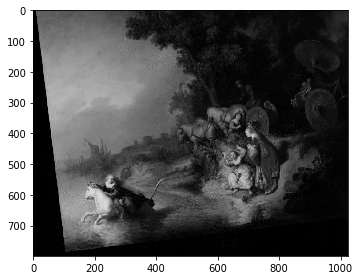

In [11]:
skimage.io.imshow(lay2);

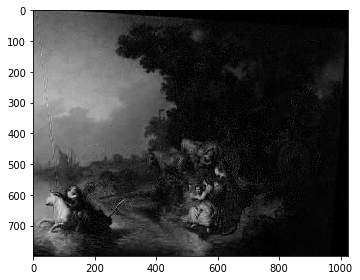

In [12]:
skimage.io.imshow(lay3);

### Возможно следующее линейное преобразование двумерной матрицы:

$$
X = a_0 * x - b_0 * y + a_1 = x * \cos(rotation) - y * \sin(rotation) + a1 \\
Y = b_0 * x + a_0 * y + b_1 = x * \sin(rotation) + y * \cos(rotation) + b1
$$

где матрица преобразования:
$$
\begin{bmatrix}
    a_{0}  & b_{0} & a_{1} \\
    b_{0}  & a_{0} & b_{1} \\
    0      & 0     & 1
\end{bmatrix}
$$
а $rotation$ - угол поворота против часовой стрелки

lay3 - против часовой; lay2 - по часовой; x in (0, 799)->int - ид строки пикселя; y in (0, 1024)->int - ид столбца пикселя

lay_i[x,y] = интенсивность пикселя i-го слоя в (х, у); A*(x, y, 1)^T

In [13]:
def id_mtx_init():
    mtx_xy = np.zeros((3, 799*1024))
    mtx_xy = mtx_xy.astype('int32')#3 строки 799x1024 столбца: первые две строки (x, y), последняя - единичная
    cnt_y = 0
    tmp_x = 0
    for i in range(3):
        for j in range(799*1024):
            if i == 0:
                if j % 1024 == 0 and j >= 1024:
                    tmp_x += 1
                mtx_xy[i, j] = tmp_x
            elif i == 1:
                if cnt_y == 1024:
                    cnt_y = 0
                mtx_xy[i, j] = cnt_y
                cnt_y += 1
            else:
                mtx_xy[i, j] = 1
    print(mtx_xy) 
    mtx_xy.shape
    return mtx_xy

In [14]:
# Ваш код
import math as m


mtx_xy = id_mtx_init()

# Поворачивает матрицу на величину сдвига shift и угол rotate
def shift_and_rotate(shift, angle):
    A = np.array([[m.cos(angle), m.sin(angle), shift[0]], [m.sin(angle), m.cos(angle), shift[1]], [0, 0, 1]])
    res = np.dot(A, mtx_xy).astype('int32')
    res[res < 0] = 0  
    res[0, :][res[0, :] > 798] = 798
    res[1, :][res[1, :] > 1023] = 1023
    return res

[[   0    0    0 ...  798  798  798]
 [   0    1    2 ... 1021 1022 1023]
 [   1    1    1 ...    1    1    1]]


In [15]:
# Ваш код
def mse(lay_1, lay_2):
    err = (lay_1 - lay_2)**2
    err_ret = err.mean()
    # print(f"mse: {err_ret}")
    return err_ret

In [16]:
def transform_layer(lay_i, list_angle, list_shift):
    mse_min = 10000
    best = None
    best_phi = 0
    best_shift = (0, 0)
    for ph in list_angle:
        for sh in list_shift:
            new_id_mtx = shift_and_rotate((sh[0], sh[1]), ph)[:2, :].T #матрица новых индексов для lay_2
            #print(new_id_mtx[:, 0].max(), new_id_mtx[:, 1].max())     
            lay_tmp = np.zeros(lay_i.shape)
            i = 0
            j = 0
            for coord in new_id_mtx:
                if j == 1024:
                    i += 1
                    j = 0
                lay_tmp[coord[0], coord[1]] = lay_i[i, j]
                j += 1
            error = mse(lay_tmp, lay1)
            if error < mse_min:
                mse_min = error
                best = lay_tmp
                best_phi = ph
                best_shift = sh
    return best, best_phi, best_shift, mse_min

In [22]:
# Ваш код
# В результате должно получиться изображение good_image, максимально близкое к оригиналу
from itertools import product
#оценки на глаз в градусах и пикселях корректирующего угла и сдвига

#layer_2
#phi (-40, -10) 
#shift ((-40 : 40), (-40 : 40))

#layer_3:
#phi (5, 20) 
#shift ((-40 : -40), (-40 : 40))
phi_lay_2 = np.arange(-45 * m.pi / 180, 0.05, 0.1)
shift_horiz_l2 = np.array(list(product(range(10, 71, 15), range(-70, -9, 15))))
print("TRANSFORMING layer_2")
tf_lay_2, phi_2, shift_2, min_mse_2 = transform_layer(lay2, phi_lay_2, shift_horiz_l2)

TRANSFORMING layer_2


Angle2|degrees|: 0.8366236104658483
Shift2|pixels|: [ 55 -70]
minMSE|layer2_transformed|: 1028.781817115144


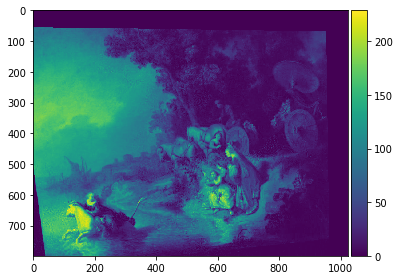

In [23]:
tf_lay_2 = tf_lay_2.astype('uint32')
skimage.io.imshow(tf_lay_2);
print(f"Angle2|degrees|: {phi_2*180/m.pi}")
print(f"Shift2|pixels|: {shift_2}")
print(f"minMSE|layer2_transformed|: {min_mse_2}")

In [24]:
phi_lay_3 = np.arange(-10 * m.pi / 180, 30 * m.pi / 180, 0.1)
shift_vertic_l3 = np.array(list(product(range(-20, 41, 15), range(-10, 51, 15))))
print("TRANSFORMING layer_3")
tf_lay_3, phi_3, shift_3, min_mse_3 = transform_layer(lay3, phi_lay_3, shift_vertic_l3)

TRANSFORMING layer_3


Angle3|degrees|: 1.4591559026164655
Shift3|pixels|: [-20 -10]
minMSE|layer3_transformed|: 1516.0679279274875


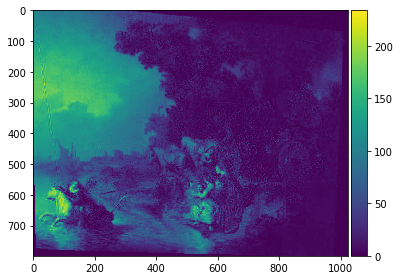

In [25]:
tf_lay_3 = tf_lay_3.astype('uint32')
skimage.io.imshow(tf_lay_3);
print(f"Angle3|degrees|: {phi_3*180/m.pi}")
print(f"Shift3|pixels|: {shift_3}")
print(f"minMSE|layer3_transformed|: {min_mse_3}")

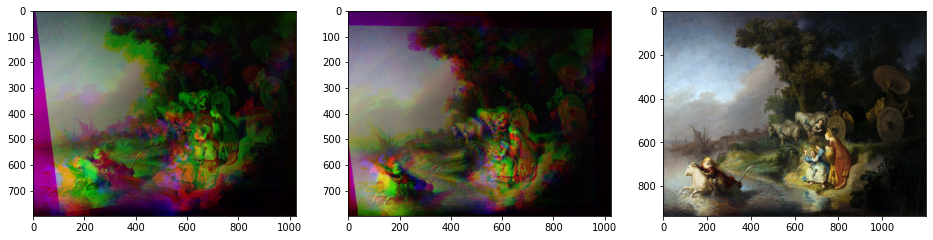

In [26]:
bad_image_new = np.dstack([lay1, tf_lay_2, tf_lay_3]).astype('uint8')
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 40))
ax[0].imshow(bad_image);
ax[1].imshow(bad_image_new);
ax[2].imshow(image);

### Вопрос 3:
Каковы значения (градусах и пикселях) для:
* Слой 0. Угол поворота $\alpha_0$, сдвиг $y_0$, сдвиг $x_0$
* Слой 1. Угол поворота $\alpha_1$, сдвиг $y_1$, сдвиг $x_1$
* Слой 2. Угол поворота$\alpha_2$, сдвиг $y_2$, сдвиг $x_2$

### Вопрос 4:
* Какой слой отвечает за какой цвет?
* Как Вы это определили?

### Вопрос 5:
* Можно ли было лучше восстановить изображение?
* Если да, то как?
* Если нет, то почему?